In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import xml.etree.ElementTree as ET
import pandas as pd

from tqdm.notebook import tqdm
from src.utils import calculate_IoU, selective_search, region_proposal, non_max_suppression, plot_one_box

cv2.setUseOptimized(True)

In [2]:
calculate_IoU((2, 2, 4, 4), (2, 2, 5, 5))

0.4444444444444444

## Selective search

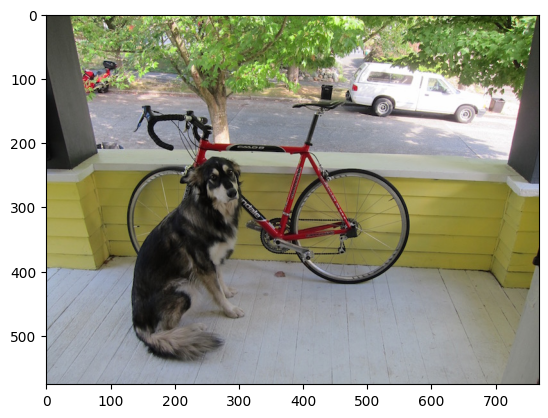

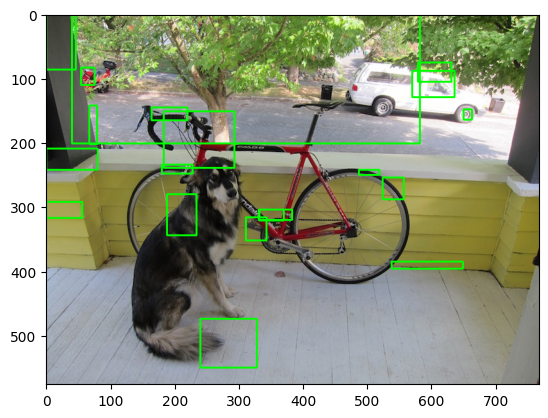

In [3]:
img = cv2.imread("./sample_images/dog_bike_car.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# img[50:100, 8:100] = 255 $ first dimension is height (left to right) and second dimension is width (top to bottom)
plt.imshow(img)
plt.show()

rects = selective_search(img, 'fast')
clone = img.copy()
for x, y, w, h in rects[:20]:
    cv2.rectangle(clone, (x, y), (x+w, y+h), (0, 255, 0), 2)
plt.imshow(clone)
plt.show()

## Region proposal

In [4]:
img, regions, bboxes = region_proposal('./sample_images/dog_bike_car.jpg')
print("[INFO] number of regions: {}".format(len(regions)))

[INFO] number of regions: 1151


In [5]:
def plot_regions(img, regions, bboxes):

    # show regions on the image first
    clone = img.copy()
    for x, y, w, h in bboxes[:20]:
        cv2.rectangle(clone, (x, y), (x+w, y+h), (0, 255, 0), 2)
    plt.imshow(clone)
    plt.show()

    fig, ax = plt.subplots(3, 5, figsize=(20, 10))
    for i in range(5):
        ax[0, i].imshow(regions[i])
        ax[1, i].imshow(regions[i+5])
        ax[2, i].imshow(regions[i+10])
        ax[0, i].axis('off')
        ax[1, i].axis('off')
        ax[2, i].axis('off')
    plt.tight_layout()
    plt.show()

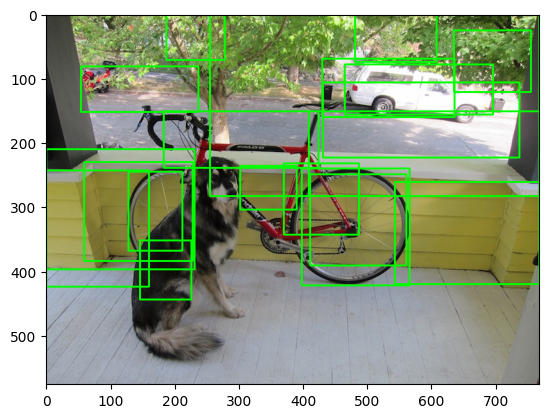

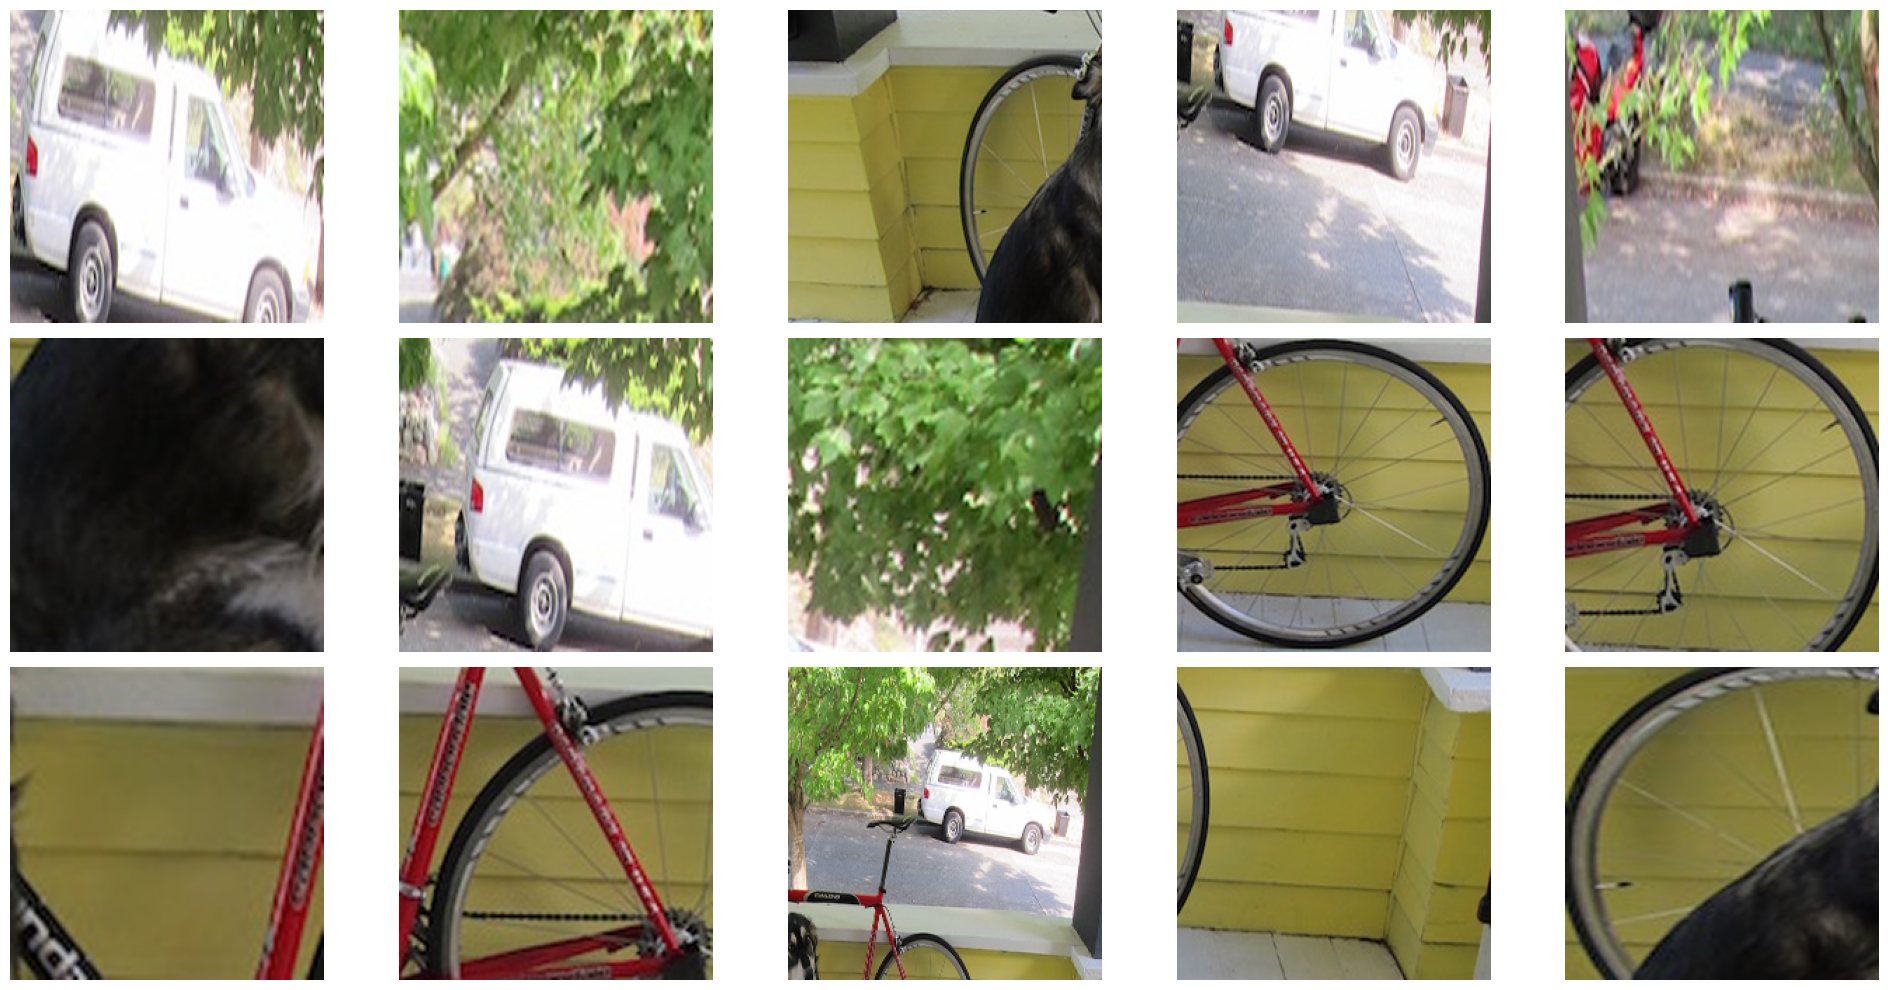

In [6]:
plot_regions(img, regions, bboxes)

## Pretrained model

In [7]:
# weights = torchvision.models.VGG16_Weights.IMAGENET1K_V1
# model = torchvision.models.vgg16(weights=weights)
weights = torchvision.models.ResNet50_Weights.IMAGENET1K_V2
model = torchvision.models.resnet50(weights=weights)
model.eval()
transforms = weights.transforms()

## Perform detection

In [8]:
def predict(images, model, transforms):
    # permute with batch at the beginning
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    outputs = []
    with torch.no_grad():
        dataloader = torch.utils.data.DataLoader(images, batch_size=32, shuffle=False)
        for batch in tqdm(dataloader):
            input = transforms(torch.tensor(batch, dtype=torch.float32).permute(0, 3, 1, 2) / 255)
            input = input.to(device)
            output = model(input)
            outputs.extend(output)
    return outputs

def decode_outputs(outputs, classes, bboxes, threshold=0.5):
    labels = {}
    
    for i, _ in enumerate(outputs):
        prediction = outputs[i].softmax(0)
        class_id = prediction.argmax().item()
        score = prediction[class_id].item()
        label = classes[class_id]
        
        if score >= threshold and label in classes:
            (x, y, w, h) = bboxes[i]
            box = (x, y, x + w, y + h)
            L = labels.get(label, [])
            L.append((box, score))
            labels[label] = L
            
    return labels

In [9]:
outputs = predict(regions, model, transforms)
labels = decode_outputs(outputs, weights.meta["categories"], bboxes, threshold=0.5)

  0%|          | 0/36 [00:00<?, ?it/s]

C:\Users\trmin\AppData\Local\Temp\ipykernel_17868\511689000.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = transforms(torch.tensor(batch, dtype=torch.float32).permute(0, 3, 1, 2) / 255)


## Show detection result on image

In [10]:
def plot_labels(img, labels, bboxes):
    # loop over the labels for each of detected objects in the image
    clone = img.copy()
    img_height, img_width, _ = img.shape
    font_size = img_height / 1500 + 0.25
    line_width = img_height // 250 + 1
    for label in labels.keys():
        # if label == "":
        #     continue
        boxes = np.array([p[0] for p in labels[label]])
        proba = np.array([p[1] for p in labels[label]])
        boxes = non_max_suppression(boxes, proba, 0.1)
        
        for (startX, startY, endX, endY) in boxes:
        # draw the bounding box and label on the image
            # cv2.rectangle(clone, (startX, startY), (endX, endY), (0, 255, 0), line_width)
            # y = startY - 10 if startY - 10 > 10 else startY + 10
            # cv2.putText(clone, f"{label} {proba[0]:.2f}", (startX, y), cv2.QT_FONT_NORMAL, font_size, (0, 255, 0), 2)
            plot_one_box((startX, startY, endX, endY), clone, label=f"{label} {proba[0]:.2f}")
            
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    ax[0].imshow(img)
    ax[1].imshow(clone)
    plt.tight_layout()
    plt.show()

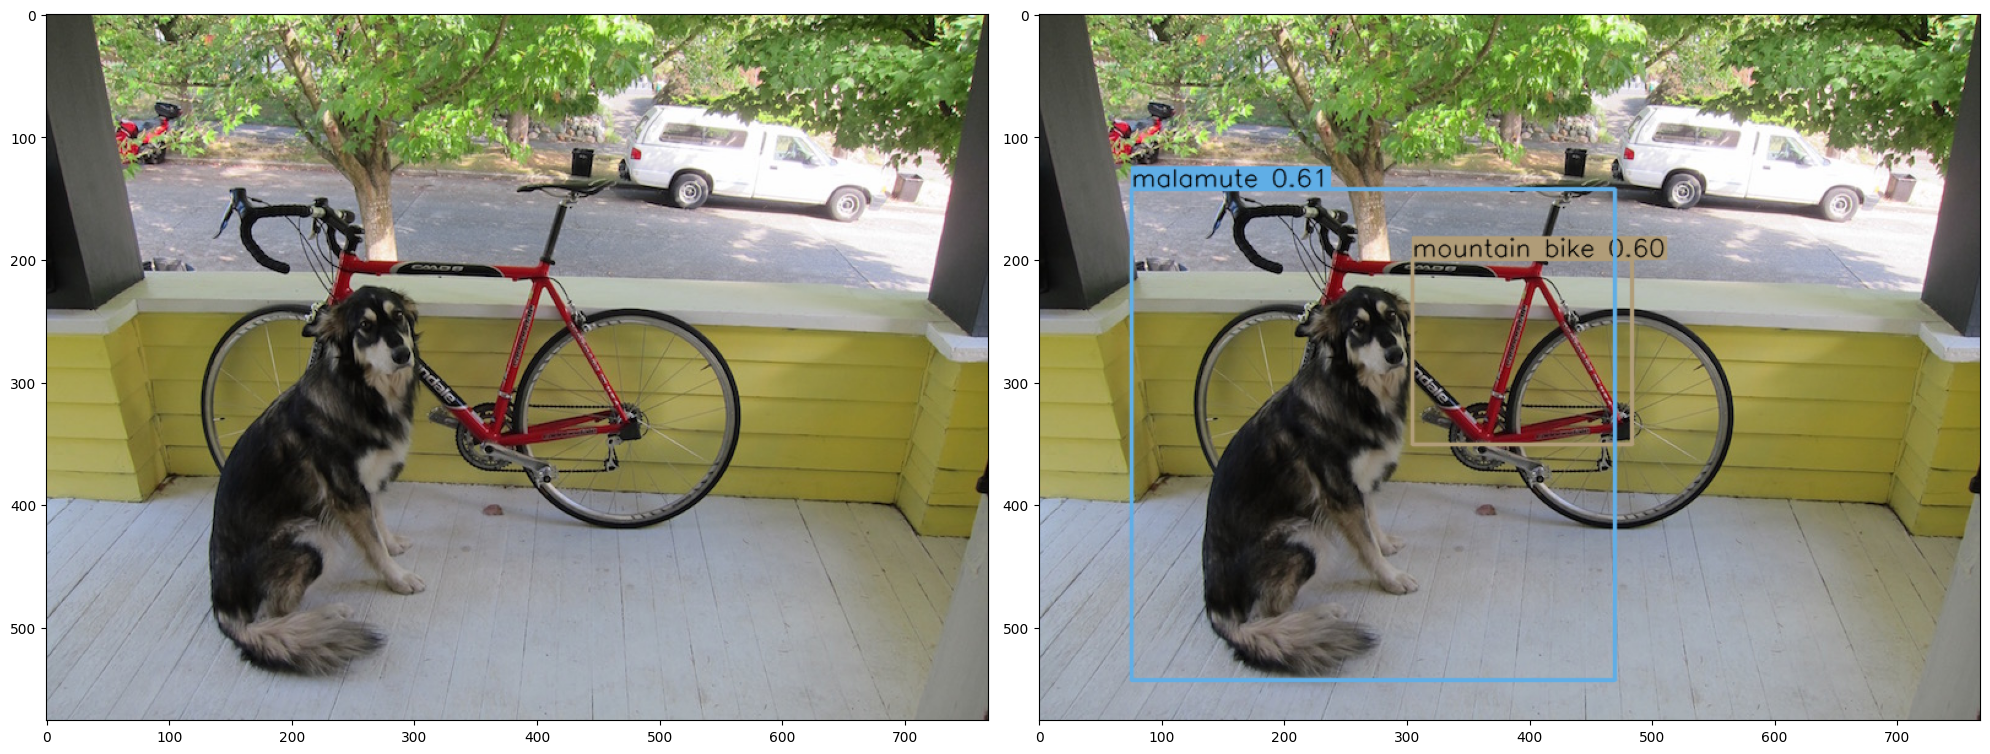

In [11]:
plot_labels(img, labels, bboxes)

## Pipeline

In [12]:
weights = torchvision.models.ResNet50_Weights.IMAGENET1K_V2
model = torchvision.models.resnet50(weights=weights)
model.eval()
transforms = weights.transforms()
classes = weights.meta["categories"]

def detect(img, model, classes, transforms, threshold=0.5):
    img, regions, bboxes = region_proposal(img)
    print("[INFO] number of regions: {}".format(len(regions)))
    
    # model predict each region
    outputs = predict(regions, model, transforms)
    assert len(outputs) == len(regions) == len(bboxes), f"outputs: {len(outputs)}, regions: {len(regions)}, bboxes: {len(bboxes)}, they should be equal"
    
    # decode outputs into labels
    labels = decode_outputs(outputs, classes, bboxes, threshold=threshold)
    print("[INFO] number of objects: {}".format(len(labels)))
    
    # plot labels
    plot_labels(img, labels, bboxes)

[INFO] number of regions: 613


  0%|          | 0/20 [00:00<?, ?it/s]

C:\Users\trmin\AppData\Local\Temp\ipykernel_17868\511689000.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = transforms(torch.tensor(batch, dtype=torch.float32).permute(0, 3, 1, 2) / 255)


[INFO] number of objects: 2


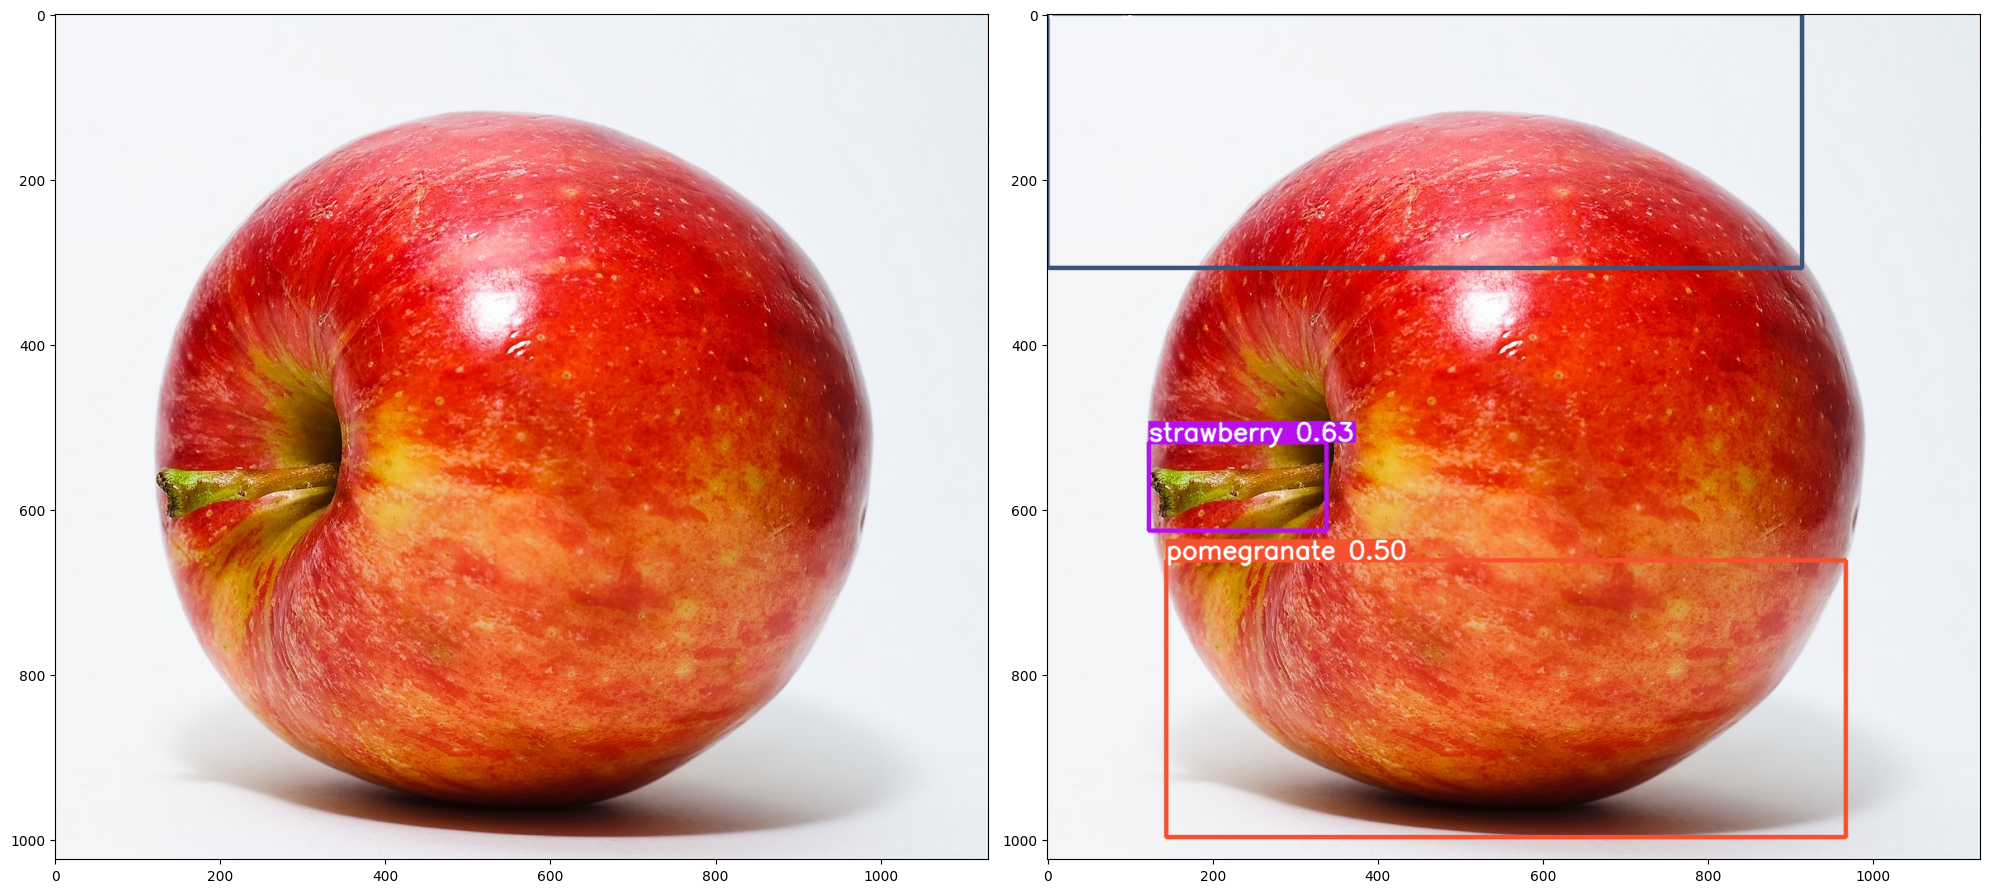

In [13]:
detect('./sample_images/apple.jpg', model, classes, transforms, threshold=0.5)

[INFO] number of regions: 1220


  0%|          | 0/39 [00:00<?, ?it/s]

C:\Users\trmin\AppData\Local\Temp\ipykernel_17868\511689000.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = transforms(torch.tensor(batch, dtype=torch.float32).permute(0, 3, 1, 2) / 255)


[INFO] number of objects: 3


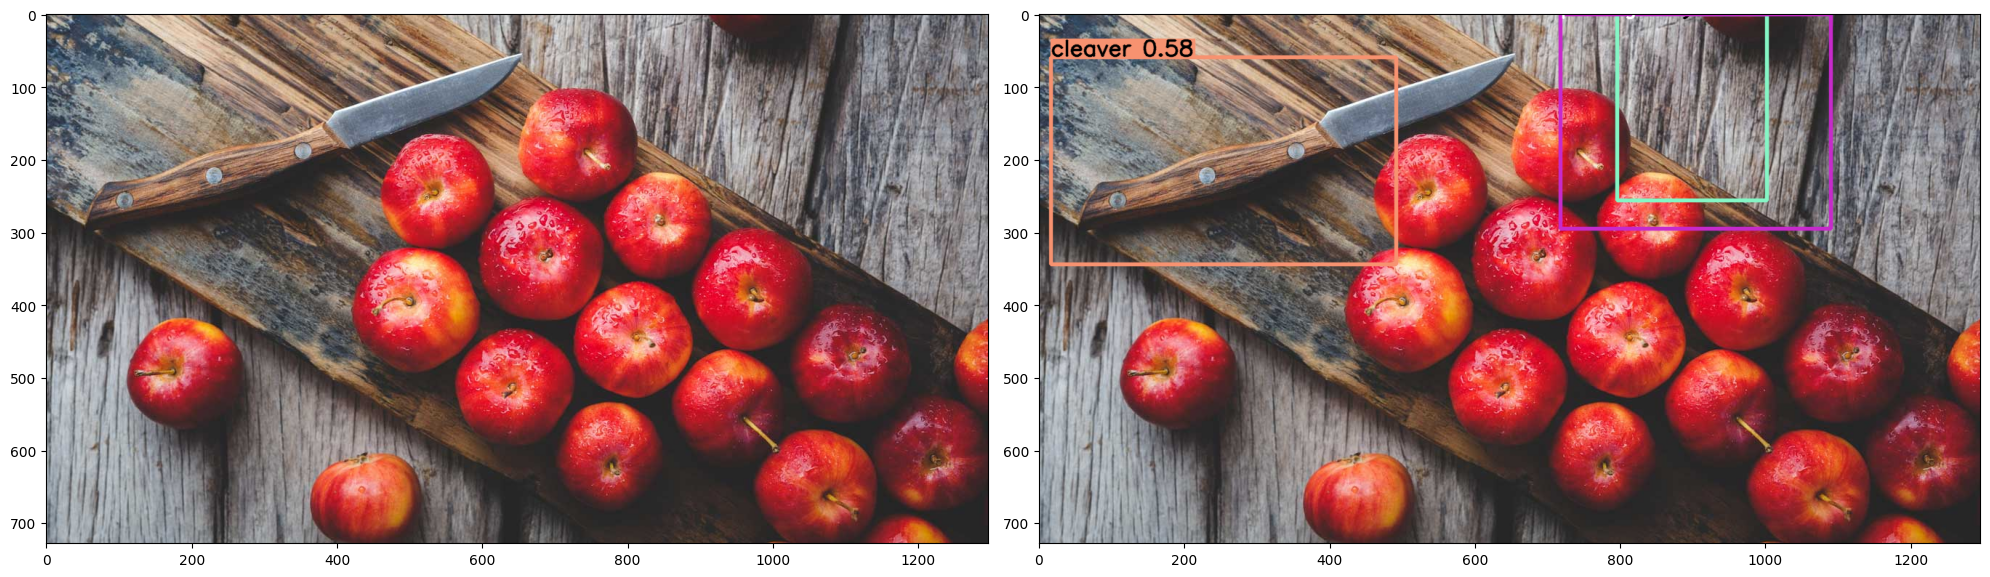

In [14]:
detect('./sample_images/apples.jpg', model, classes, transforms, threshold=0.5)

[INFO] number of regions: 403


  0%|          | 0/13 [00:00<?, ?it/s]

C:\Users\trmin\AppData\Local\Temp\ipykernel_17868\511689000.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = transforms(torch.tensor(batch, dtype=torch.float32).permute(0, 3, 1, 2) / 255)


[INFO] number of objects: 3


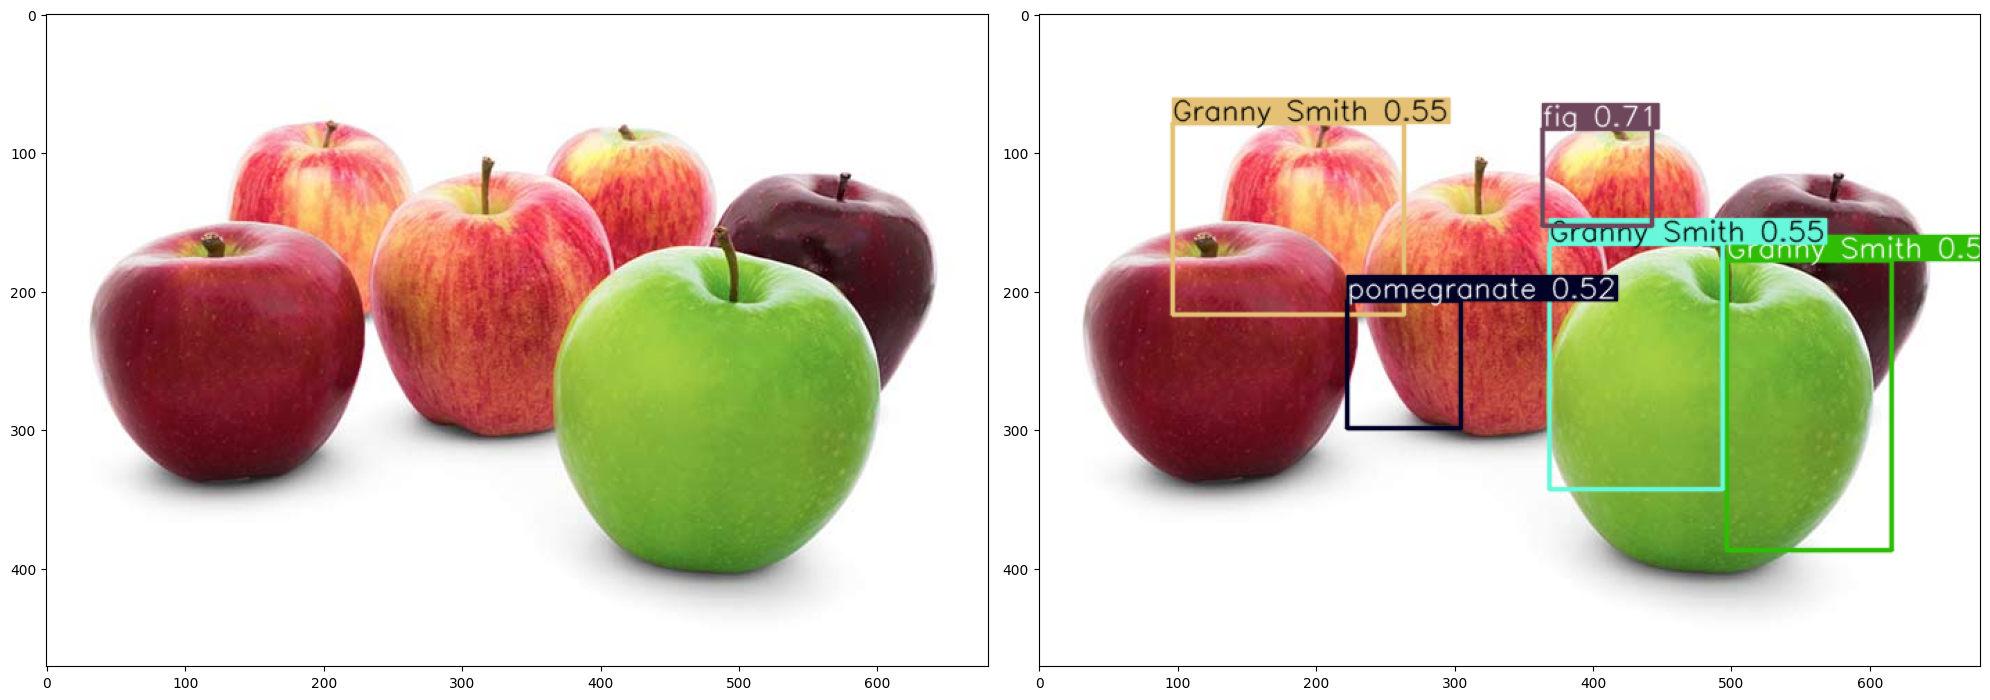

In [15]:
detect('./sample_images/apples2.jpg', model, classes, transforms, threshold=0.5)